##Setup

You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

In [ ]:
#@title mount your Google Drive
#@markdown Your work will be stored in a folder called `cs285_f2022` by default to prevent Colab instance timeouts from deleting your edits.

import os
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#@title set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs285_f2022'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs285_f2022'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

!apt update 
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        xvfb \
        python-opengl \
        ffmpeg

In [ ]:
#@title clone homework repo

%cd $SYM_PATH
!git clone https://github.com/berkeleydeeprlcourse/homework_fall2022.git
%cd homework_fall2022/hw1
%pip install -r requirements_colab.txt
%pip install -e .

In [ ]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
#@title test virtual display

#@markdown If you see a video of a four-legged ant fumbling about, setup is complete!

import gym
from cs285.infrastructure.colab_utils import (
    wrap_env,
    show_video
)

env = wrap_env(gym.make("Ant-v4", render_mode='rgb_array'))

observation = env.reset()
for i in range(100):
    env.render()
    obs, rew, term, _ = env.step(env.action_space.sample() ) 
    if term:
      break;
            
env.close()
print('Loading video...')
show_video()

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import glob
plt.rcParams.update({'font.size': 18})

def eventfile_to_dict(file):
    output = {}
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.tag in output:
                output[v.tag].append(v.simple_value)
            else:
                output[v.tag] = [v.simple_value]
    return output

def plot_mean_std(x,ys,yerrors,labels):
    for i,label in enumerate(labels):
        plt.plot(x,ys[i])
        plt.fill_between(x,ys[i]-yerrors[i],ys[i]+yerrors[i],alpha=0.3,label=label)
    plt.legend()

## Question 1.3

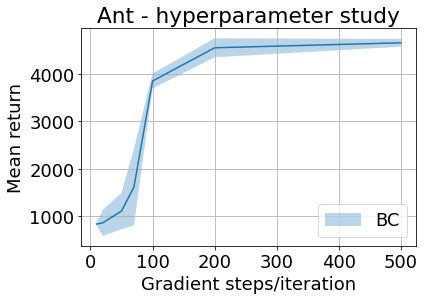

In [238]:
logdir = '../../data/q1_bc_ant_trainsteps*/events*'
trainsteps = [10,20,50,70,100,200,500]
eval_returns = np.zeros((len(trainsteps),2))
for eventfile in glob.glob(logdir):
    result = eventfile_to_dict(eventfile)
    trainstep = int(eventfile.split('_')[3][10:])
    eval_returns[trainsteps.index(trainstep)] = [result['Eval_AverageReturn'][0],result['Eval_StdReturn'][0]]
    
plot_mean_std(trainsteps,[eval_returns[:,0]],[eval_returns[:,1]],['BC'])
plt.xlabel('Gradient steps/iteration')
plt.ylabel('Mean return')
plt.title('Ant - hyperparameter study')
plt.grid()
plt.show()

## Question 2.2

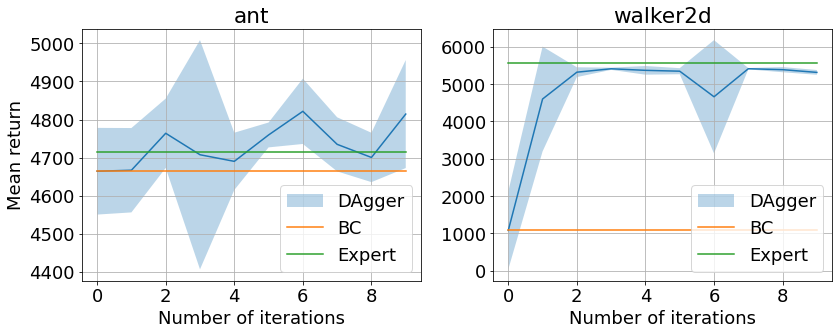

In [249]:
runs = ['ant','walker2d']
labels = ['DAgger']
plt.figure(figsize=(12,5))
for i,run in enumerate(runs):
    plt.subplot(1,2,i+1)
    logdir = f'../../data/q2_dagger_{run}_evalbatch5000_*/events*'
    result = eventfile_to_dict(glob.glob(logdir)[0])

    # DAgger
    eval_means = np.array([result['Eval_AverageReturn']])
    eval_stds= np.array([result['Eval_StdReturn']])
    n_iter = len(eval_means[0])
    plot_mean_std(range(n_iter),eval_means,eval_stds,labels)

    # BC & Expert
    plt.plot(result['Eval_AverageReturn'][0]*np.ones(n_iter),label='BC')
    plt.plot(result['Initial_DataCollection_AverageReturn'],label='Expert')
    plt.title(run)
    plt.xlabel('Number of iterations')
    if i == 0:
        plt.ylabel('Mean return')
    plt.legend(loc='lower right')
    plt.grid()
plt.tight_layout()
plt.show()

## Tests: relabel, evalbatch

['../../data/q2_dagger_walker2d_relabel_Walker2d-v4_11-09-2022_11-58-23/events.out.tfevents.1662922703.Nams-Air.localdomain']
['../../data/q2_dagger_walker2d_norelabel_Walker2d-v4_11-09-2022_11-51-23/events.out.tfevents.1662922283.Nams-Air.localdomain']


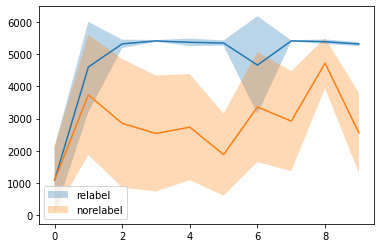

In [186]:
eval_means, eval_stds = [],[]
labels = ['relabel','norelabel']
for label in labels:
    logdir = f'../../data/q2_dagger_walker2d_{label}*/events*'
    print(glob.glob(logdir))
    result = eventfile_to_dict(glob.glob(logdir)[0])
    eval_means.append(result['Eval_AverageReturn'])
    eval_stds.append(result['Eval_StdReturn'])
eval_means = np.array(eval_means)
eval_stds = np.array(eval_stds)
plot_mean_std(range(len(eval_means[0])),eval_means,eval_stds,labels)


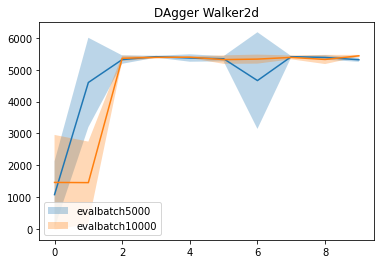

In [189]:
eval_means, eval_stds = [],[]
labels = ['evalbatch5000','evalbatch10000']
for label in labels:
    logdir = f'../../data/q2_dagger_walker2d_{label}*/events*'
    result = eventfile_to_dict(glob.glob(logdir)[0])
    eval_means.append(result['Eval_AverageReturn'])
    eval_stds.append(result['Eval_StdReturn'])
eval_means = np.array(eval_means)
eval_stds = np.array(eval_stds)
plot_mean_std(range(len(eval_means[0])),eval_means,eval_stds,labels)
plt.title('DAgger Walker2d')
plt.show()

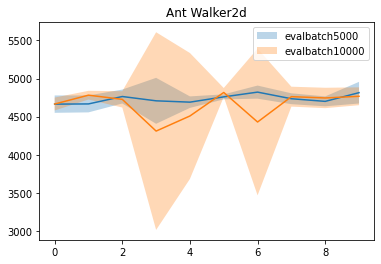

In [191]:
eval_means, eval_stds = [],[]
labels = ['evalbatch5000','evalbatch10000']
for label in labels:
    logdir = f'../../data/q2_dagger_ant_{label}*/events*'
    result = eventfile_to_dict(glob.glob(logdir)[0])
    eval_means.append(result['Eval_AverageReturn'])
    eval_stds.append(result['Eval_StdReturn'])
eval_means = np.array(eval_means)
eval_stds = np.array(eval_stds)
plot_mean_std(range(len(eval_means[0])),eval_means,eval_stds,labels)
plt.title('Ant Walker2d')
plt.show()

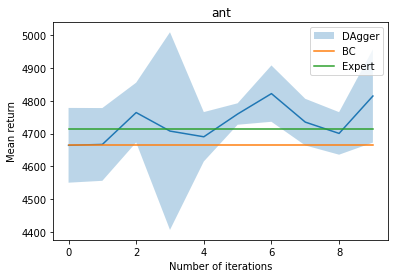

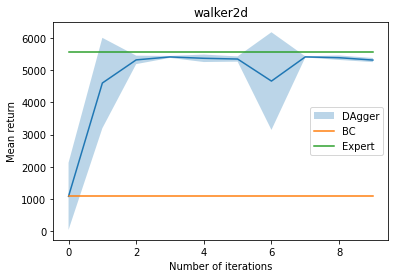